In [1]:
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import data_preprocessing
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from tsfresh import extract_features
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding,LSTM


In [8]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
def csv_to_json(csv_file_path, json_file_path):
    # Read the CSV data
    df = pd.read_csv(csv_file_path)

    # Convert the CSV data to JSON
    json_data = df.to_json(orient='records')

    # Write the JSON data to a file
    with open(json_file_path, 'w') as json_file:
        json_file.write(json_data)
    



In [9]:
path_dataset = r'small_dataset.csv'
path_json = r'C:\Users\fiete\PycharmProjects\boxklassifikation\Boxschlag-Klassifikation\.json'
csv_to_json(path_dataset, path_json)

In [313]:
# Normalisierung der Daten
"""
Gerne mit periodLengthMS und sampling sampleRateUS rumspielen. Den Effekt von den Variablen könnt ihr in smartPunch_tutorial_ManipulatePeriodLength.ipynb sehen.  
"""
import json
import prepro

periodLengthMS = 1000
sampleRateUS = 10000


with open('datav1.json', 'r') as f:
    dsds = json.load(f)





ds = prepro.jsonData_to_dataset_in_timedifference_us(dsds)

df_new = prepro.normate_dataset_period(periodLengthMS, sampleRateUS, ds)

Starting new normalization/interpolation...
progress: 0.04 %
progress: 0.08 %
progress: 0.13 %
progress: 0.17 %
progress: 0.21 %
progress: 0.25 %
progress: 0.30 %
progress: 0.34 %
progress: 0.38 %
progress: 0.42 %
progress: 0.47 %
progress: 0.51 %
progress: 0.55 %
progress: 0.59 %
progress: 0.64 %
progress: 0.68 %
progress: 0.72 %
progress: 0.76 %
progress: 0.81 %
progress: 0.85 %
progress: 0.89 %
progress: 0.93 %
progress: 0.98 %
progress: 1.02 %
progress: 1.06 %
progress: 1.10 %
progress: 1.15 %
progress: 1.19 %
progress: 1.23 %
progress: 1.27 %
progress: 1.32 %
progress: 1.36 %
progress: 1.40 %
progress: 1.44 %
progress: 1.48 %
progress: 1.53 %
progress: 1.57 %
progress: 1.61 %
progress: 1.65 %
progress: 1.70 %
progress: 1.74 %
progress: 1.78 %
progress: 1.82 %
progress: 1.87 %
progress: 1.91 %
progress: 1.95 %
progress: 1.99 %
progress: 2.04 %
progress: 2.08 %
progress: 2.12 %
progress: 2.16 %
progress: 2.21 %
progress: 2.25 %
progress: 2.29 %
progress: 2.33 %
progress: 2.38 %
prog

In [381]:
len(df_new)

2357

In [390]:
df_list = pd.DataFrame({'idx': range(len(df_new)), 'dfs': df_new})['dfs'].values.tolist()

In [391]:
type(df_list)

list

In [392]:
x_train,y_train = [],[]

for df in df_list:
    y_train.append(df["label"].iloc[0])
    x_train.append(df.drop(columns=["timestamp", "label"]).values)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape, y_train.shape

((2357, 101, 3), (2357,))

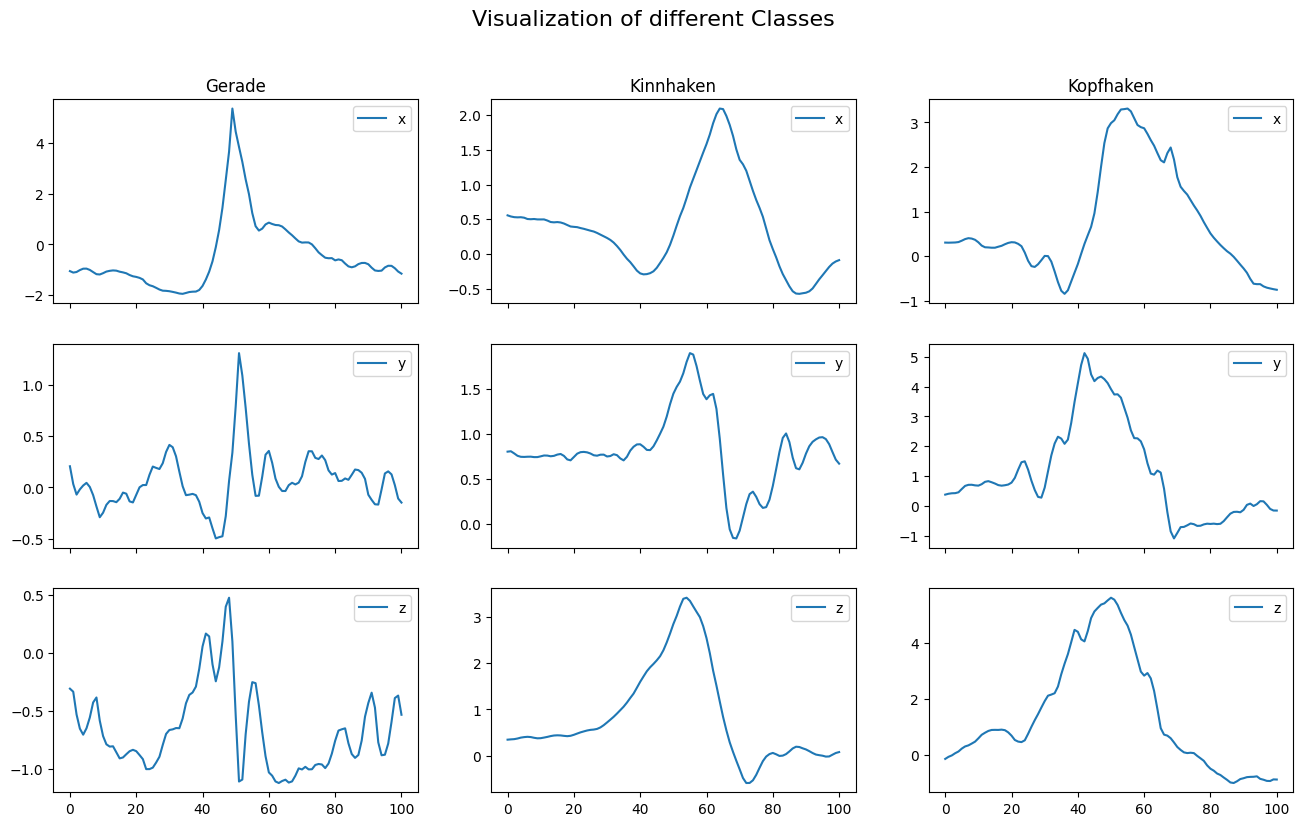

In [393]:

# Set classes to visualize and set the feature names
FEATURE_NAMES = ['x', 'y', 'z']
CLASSES = ['Gerade', 'Kinnhaken', 'Kopfhaken']

fig, axs = plt.subplots(nrows=3, ncols=len(CLASSES), sharex=True, sharey=False)
fig.suptitle('Visualization of different Classes', fontsize=16)
fig.set_size_inches(16, 9)
x = np.arange(101)                                  #!!!!!! hier die dimensionen angeben 
for index, cls in enumerate(CLASSES):
    # Set class as label for top subplot of each column
    axs[0][index].set(title=cls)
    # Get random instance from training data with corresponding class
    instance_index = np.random.choice(np.argwhere(y_train == cls).flatten())
    instance = x_train[instance_index]
    # Plot the feature groups (all axis of one measurement) in the different subplots and add labels
    for sublot in [0, 1, 2]:
        axs[sublot][index].plot(x, instance[:, sublot])
        axs[sublot][index].legend(FEATURE_NAMES[sublot])
plt.show()

In [394]:
_label = ['Gerade', 'Kinnhaken', 'Kopfhaken']
category_to_num = {element: num for num, element in enumerate(_label)}
numerical_data = np.vectorize(category_to_num.get)(y_train)


y_train  = np.array(numerical_data)

In [395]:
print(y_train[1])

0


In [403]:
print(len(sk_X_test))
print(len(sk_y_test))

472
472


In [396]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(x_train, y_train, test_size=0.2)


In [397]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, Masking, Input
from tensorflow.keras.layers import Activation,Conv1D,MaxPooling1D, Flatten
from keras import layers
from keras import regularizers

#--------------------------testing cnns


model = Sequential()
model.add(Input(shape=sk_X_train[1].shape))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.L2(0.02)))  # Increased regularization
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Increased dropout
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.L2(0.02)))  # Reduced complexity and increased regularization
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Increased dropout
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.02)))  # Reduced complexity and increased regularization
model.add(Dropout(0.3))  # Increased dropout
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [305]:
#---------------------------------------------RNN BY NILS

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, Masking, Input


"""

"""
# Definiere das Modell
model0 = keras.models.Sequential([
    InputLayer(shape=x_train[1].shape),
    SimpleRNN(units=256, activation='relu', return_sequences=True),
    Dropout(rate=0.2),  # Dropout zur Regularisierung
    SimpleRNN(units=256, activation='relu', return_sequences=True),
    Dropout(rate=0.2),  # Dropout zur Regularisierung
    SimpleRNN(units=256, activation='relu', return_sequences=False),
    Dropout(rate=0.2),  # Dropout zur Regularisierung
    Dense(3, activation='softmax')  # Ausgangsschicht für 3 Klassen
])

model0.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


# Zusammenfassung des Modells ausdrucken
print(model0.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 101, 256)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 101, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 101, 256)       │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 101, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,987 (1.26 MB)

 Trainable params: 329,987 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

None


numpy.ndarray

In [196]:
#--------------------------testing RNNs
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, Masking, Input

from tensorflow.keras import layers




# Definiere das Modell
model1 = Sequential()
model1.add(InputLayer(shape=sk_X_train[1].shape))
model1.add(LSTM(units=64, return_sequences=True, activation = "relu"))
model1.add(LSTM(units=32, return_sequences=False, activation = "relu"))
#model1.add(LSTM(units=32, return_sequences=True, activation = "relu"))
#model1.add(LSTM(units=16, return_sequences=False, activation = "relu"))
model1.add(Dense(3, activation="softmax"))  #Output und Input müssen am Ende die selbe shape haben -> mittlere Spalte der Tabelle 


model1.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])



# Zusammenfassung des Modells ausdrucken
print(model1.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 101, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [475]:
len(sk_X_train)

1885

Epoch 1/30
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9494 - loss: 0.7804
Epoch 1: val_accuracy improved from -inf to 0.96021, saving model to cnn.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9454 - loss: 0.7822 - val_accuracy: 0.9602 - val_loss: 0.7328
Epoch 2/30
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9519 - loss: 0.7566
Epoch 2: val_accuracy improved from 0.96021 to 0.97082, saving model to cnn.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9509 - loss: 0.7525 - val_accuracy: 0.9708 - val_loss: 0.6982
Epoch 3/30
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9430 - loss: 0.7475
Epoch 3: val_accuracy did not improve from 0.97082
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9419 - loss: 0.7528 - val_accuracy: 0.9708 - val_loss: 0.7058
Epoch 4/30
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9550 - loss: 0.7286
Epoch 4: val_accuracy improved from 0.97082 to 0.97347, saving model to cnn.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms

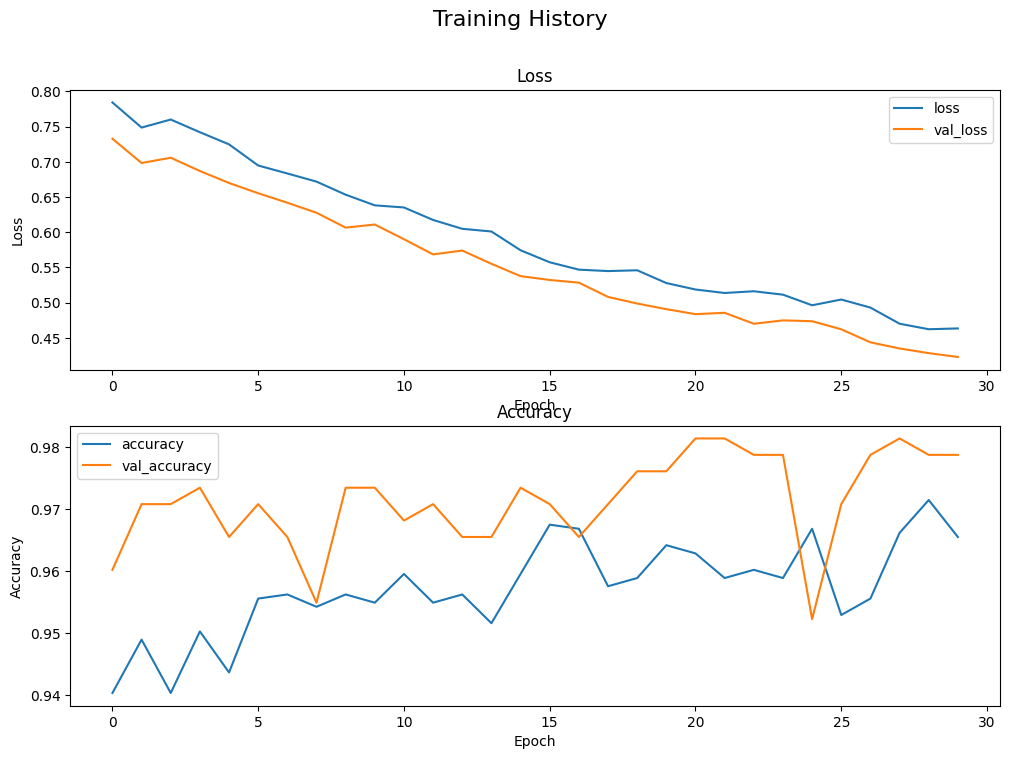

In [473]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding,LSTM

# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 300
EPOCHS = 30

# Encode the labels using One-Hot-Encoding
y_train_encoded = tf.one_hot(indices=sk_y_train, depth=3)


checkpoint_filepath = 'cnn.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose = 1
)



early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train model using validation split
history = model.fit(x=sk_X_train, y=y_train_encoded, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback, early_stopping])


# Plot the training histroy
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()



In [481]:
counts = np.bincount(sk_y_train)

print(counts)

[620 653 612]


In [203]:
type(sk_y_test)

numpy.ndarray

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


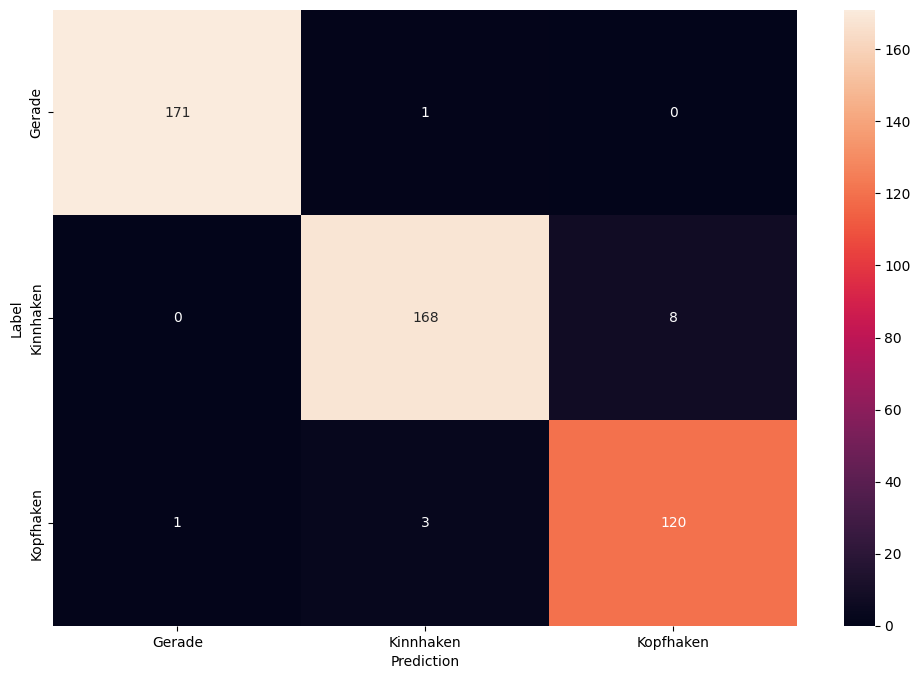

In [474]:
y_predicted = np.argmax(model.predict(x=sk_X_test), axis=1)
confusion_matrix = tf.math.confusion_matrix(labels=sk_y_test, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=CLASSES, yticklabels=CLASSES, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

2357

In [11]:
# Normalisierung der Daten
"""
Gerne mit periodLengthMS und sampling sampleRateUS rumspielen. Den Effekt von den Variablen könnt ihr in smartPunch_tutorial_ManipulatePeriodLength.ipynb sehen.  
"""
import json
import prepro

periodLengthMS = 1000
sampleRateUS = 10000


with open('fritz_daten.json', 'r') as f:
    dsds = json.load(f)

ds = prepro.jsonData_to_dataset_in_timedifference_us(dsds)

_df_new = prepro.normate_dataset_period(periodLengthMS, sampleRateUS, ds)

Starting new normalization/interpolation...
progress: 10.00 %
progress: 20.00 %
progress: 30.00 %
progress: 40.00 %
progress: 50.00 %
progress: 60.00 %
progress: 70.00 %
progress: 80.00 %
progress: 90.00 %
Fertig, jetzt erstmal lecker Bierchen!


In [12]:
_df_list = pd.DataFrame({'idx': range(len(_df_new)), 'dfs': _df_new})['dfs'].values.tolist()

In [13]:
_df_list[0]

,x,y,z,timestamp,label
0,-0.878048,0.095559,-0.384882,0,Gerade
1,-0.863267,0.089414,-0.370949,10000,Gerade
2,-0.841508,0.072891,-0.350507,20000,Gerade
3,-0.823698,0.050925,-0.329629,30000,Gerade
4,-0.812166,0.035463,-0.320011,40000,Gerade
...,...,...,...,...,...
96,-1.258472,-0.386467,-0.294272,960000,Gerade
97,-1.495425,-0.513620,-0.747829,970000,Gerade
98,-1.788899,-0.803866,-1.710827,980000,Gerade
99,-2.085356,-1.155481,-2.951609,990000,Gerade


In [14]:
_x_train,_y_train = [],[]

for df in _df_list:
    _y_train.append(df["label"].iloc[0])
    _x_train.append(df.drop(columns=["timestamp", "label"]).values)

_x_train = np.array(_x_train)
_y_train = np.array(_y_train)

_label = ['Gerade', 'Kinnhaken', 'Kopfhaken']
category_to_num = {element: num for num, element in enumerate(_label)}
numerical_data = np.vectorize(category_to_num.get)(_y_train)


_y_train  = np.array(numerical_data)

In [15]:
len(_y_train)

10

In [16]:
from tensorflow.keras.models import load_model

# Laden Sie das Modell aus der Datei
mymodel = load_model('cnn.keras')


In [17]:
dings = mymodel.predict(_x_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


In [18]:
dings[1] #-0    , 1    , 2  

array([0.9812485 , 0.01469453, 0.00405699], dtype=float32)

In [22]:
num_to_category = {0: 'Gerade', 1: 'Kinnhaken', 2: 'Kopfhaken'}

predicted_classes = np.argmax(dings, axis=1)

class_counts = np.bincount(predicted_classes)

for i, count in enumerate(class_counts):
    print(f"{num_to_category[i]}: {count}")

Gerade: 4
Kinnhaken: 5
Kopfhaken: 1


In [23]:
num_to_category = {0: 'Gerade', 1: 'Kinnhaken', 2: 'Kopfhaken'}

class_counts = np.bincount(_y_train)

for i, count in enumerate(class_counts):
    print(f"{num_to_category[i]}: {count}")

Gerade: 10


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


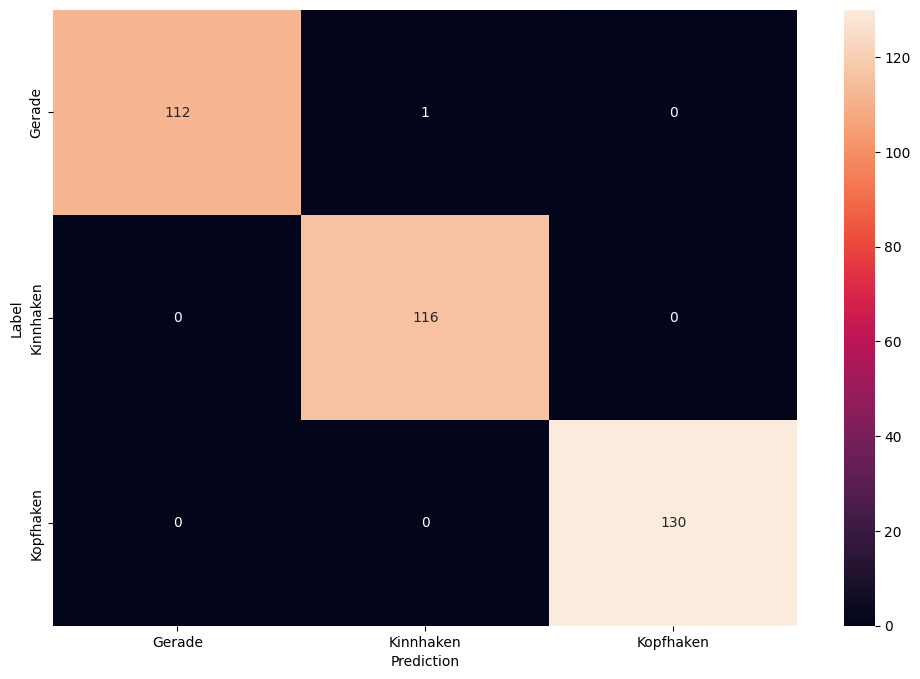

In [492]:
yoyo = model.predict(x=_x_train)
_y_predicted = np.argmax(yoyo, axis=1)
_confusion_matrix = tf.math.confusion_matrix(labels=_y_train, predictions=_y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(_confusion_matrix, xticklabels=CLASSES, yticklabels=CLASSES, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()